## Retail Customer Intelligence

Retailers often struggle to know which customers to invest in — who is worth retaining, who might leave, and how to segment them for targeted marketing. This project addresses that by building a single customer intelligence system from transaction data: we segment customers by behavior, estimate their future value (CLV), and predict churn risk so the business can prioritize retention and spend wisely.

**Part 1 of 4** — This notebook builds the shared data foundation: ingest, clean, train/holdout split, and train-window features (RFM, BG/NBD inputs, churn labels). Downstream notebooks use these for segmentation, CLV, and churn.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

PROJECT_ROOT = Path("..")
RAW_PATH = PROJECT_ROOT / "data" / "raw" / "online_retail_II.xlsx"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Raw data path: {RAW_PATH}")
print(f"Processed data will be saved to: {PROCESSED_DIR}")

Raw data path: ..\data\raw\online_retail_II.xlsx
Processed data will be saved to: ..\data\processed


## 2. Data Loading

The dataset below contains online retail transactions from a UK-based company. It includes multiple sheets spanning 2009-2011.

In [2]:
# Load Excel file and check sheets
xls = pd.ExcelFile(RAW_PATH)
print(f"Available sheets: {xls.sheet_names}")
print(f"Number of sheets: {len(xls.sheet_names)}")

Available sheets: ['Year 2009-2010', 'Year 2010-2011']
Number of sheets: 2


In [3]:
# Combine all sheets into single dataframe
df_list = []
for sheet in xls.sheet_names:
    tmp = pd.read_excel(RAW_PATH, sheet_name=sheet)
    tmp["source_sheet"] = sheet
    df_list.append(tmp)
    print(f"Loaded {sheet}: {tmp.shape[0]:,} rows")

raw = pd.concat(df_list, ignore_index=True)
print(f"\n Total combined data: {raw.shape[0]:,} rows, {raw.shape[1]} columns")



Loaded Year 2009-2010: 525,461 rows
Loaded Year 2010-2011: 541,910 rows

 Total combined data: 1,067,371 rows, 9 columns


In [4]:
raw.head()
raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Invoice       1067371 non-null  object        
 1   StockCode     1067371 non-null  object        
 2   Description   1062989 non-null  object        
 3   Quantity      1067371 non-null  int64         
 4   InvoiceDate   1067371 non-null  datetime64[us]
 5   Price         1067371 non-null  float64       
 6   Customer ID   824364 non-null   float64       
 7   Country       1067371 non-null  str           
 8   source_sheet  1067371 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), object(3), str(2)
memory usage: 73.3+ MB


In [5]:
## Data Cleaning and Preparation
# Standardize columns + parse dates
import re

def standardize_columns(cols):
    out = []
    for c in cols:
        c = c.strip()
        # Insert underscore between lower->upper: InvoiceDate -> Invoice_Date
        c = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", c)
        c = c.lower()
        c = c.replace(" ", "_")
        c = c.replace("-", "_")
        out.append(c)
    return out

raw.columns = standardize_columns(raw.columns)
raw.columns

raw["invoice_date"] = pd.to_datetime(raw["invoice_date"], errors="coerce")
raw.isnull().sum()

invoice              0
stock_code           0
description       4382
quantity             0
invoice_date         0
price                0
customer_id     243007
country              0
source_sheet         0
dtype: int64

In [6]:
raw.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'price', 'customer_id', 'country', 'source_sheet'], dtype='str')

In [7]:
## Flags + revenue + summary
raw["invoice"] = raw["invoice"].astype(str)
raw["is_cancelled"] = raw["invoice"].str.startswith("C")
raw["is_return"] = raw["quantity"] < 0

if "unit_price" not in raw.columns and "price" in raw.columns:
    raw["unit_price"] = raw["price"]

raw["revenue"] = raw["quantity"] * raw["unit_price"]

raw_summary = pd.DataFrame([{
    "rows": len(raw),
    "min_date": raw["invoice_date"].min(),
    "max_date": raw["invoice_date"].max(),
    "cancelled_rows": int(raw["is_cancelled"].sum()),
    "return_rows": int(raw["is_return"].sum()),
    "missing_customer_id": int(raw["customer_id"].isna().sum()),
    "nonpositive_price": int((raw["unit_price"] <= 0).sum()),
    "zero_qty": int((raw["quantity"] == 0).sum()),
}])

raw_summary


,rows,min_date,max_date,cancelled_rows,return_rows,missing_customer_id,nonpositive_price,zero_qty
0,1067371,2009-12-01 07:45:00,2011-12-09 12:50:00,19494,22950,243007,6207,0


#### Raw Data Observations

- The dataset contains **1,067,371 transaction-level records** spanning from **December 2009 to December 2011**.
- Approximately **19.5k transactions are cancellations**, identified by invoice numbers starting with 'C'.
- Around **22.9k rows represent product returns** (negative quantities).
- **243k rows (~23%) lack a customer_id**, which prevents customer-level attribution.
- A small number of rows (**~6.2k**) contain **non-positive prices**, indicating data quality issues.

#### Interpretation
- Cancellation and return records do not represent completed purchases and would distort revenue and purchase frequency if treated as sales.
- Missing customer identifiers make it difficult to compute customer-level features such as recency, frequency, and lifetime value.
- These observations suggest proper cleaning before any customer analytics or modeling is performed.


### Data Cleaning

In [8]:
## Data Cleaning and Preparation

clean = raw.copy()

before_rows = len(clean)

# 1. Remove cancelled invoices
clean = clean[~clean["is_cancelled"]]

# 2. Remove missing customer_id (cannot support customer-level modeling)
clean = clean[clean["customer_id"].notna()]

# 3. Remove non-positive prices
clean = clean[clean["unit_price"] > 0]

# 4. Remove non-positive quantities (returns and invalid rows)
clean = clean[clean["quantity"] > 0]

after_rows = len(clean)

pd.DataFrame([{
    "rows_before": before_rows,
    "rows_after": after_rows,
    "rows_removed": before_rows - after_rows
}])


,rows_before,rows_after,rows_removed
0,1067371,805549,261822


In [9]:
clean_summary = pd.DataFrame([{
    "rows": len(clean),
    "min_date": clean["invoice_date"].min(),
    "max_date": clean["invoice_date"].max(),
    "remaining_missing_customer_id": int(clean["customer_id"].isna().sum()),
    "remaining_nonpositive_price": int((clean["unit_price"] <= 0).sum()),
    "remaining_nonpositive_qty": int((clean["quantity"] <= 0).sum()),
}])

clean_summary


,rows,min_date,max_date,remaining_missing_customer_id,remaining_nonpositive_price,remaining_nonpositive_qty
0,805549,2009-12-01 07:45:00,2011-12-09 12:50:00,0,0,0


#### Save Cleaned Transactions for Reuse

We save a clean, transaction-level table so all downstream notebooks use the same inputs.

In [10]:
# Save cleaned transactions for downstream modeling
cols = [
    "invoice",
    "invoice_date",
    "customer_id",
    "quantity",
    "unit_price",
    "revenue",
    "country",
    "source_sheet",
]
cols = [c for c in cols if c in clean.columns]

transactions_clean = clean[cols].copy()
transactions_clean.to_csv(PROCESSED_DIR / "transactions_clean.csv", index=False)
transactions_clean.head()


,invoice,invoice_date,customer_id,quantity,unit_price,revenue,country,source_sheet
0,489434,2009-12-01 07:45:00,13085.0,12,6.95,83.4,United Kingdom,Year 2009-2010
1,489434,2009-12-01 07:45:00,13085.0,12,6.75,81.0,United Kingdom,Year 2009-2010
2,489434,2009-12-01 07:45:00,13085.0,12,6.75,81.0,United Kingdom,Year 2009-2010
3,489434,2009-12-01 07:45:00,13085.0,48,2.10,100.8,United Kingdom,Year 2009-2010
4,489434,2009-12-01 07:45:00,13085.0,24,1.25,30.0,United Kingdom,Year 2009-2010


#### Define Snapshot and Train/Holdout Split

We use a time-based split to prevent leakage and ensure churn/CLV are evaluated on future behavior.

In [11]:
# Snapshot date and holdout window
snapshot_date = clean["invoice_date"].max()
HOLDOUT_DAYS = 90
train_end = snapshot_date - pd.Timedelta(days=HOLDOUT_DAYS)

train = clean[clean["invoice_date"] <= train_end].copy()
holdout = clean[clean["invoice_date"] > train_end].copy()

pd.DataFrame([
    {
        "snapshot_date": snapshot_date,
        "train_end": train_end,
        "train_rows": len(train),
        "holdout_rows": len(holdout),
        "holdout_days": HOLDOUT_DAYS,
    }
])


,snapshot_date,train_end,train_rows,holdout_rows,holdout_days
0,2011-12-09 12:50:00,2011-09-10 12:50:00,644022,161527,90


#### Create Churn Labels (Holdout Window)

A customer is labeled churned if they had no purchases in the holdout window.

In [12]:
# Churn labels based on holdout activity
train_customers = set(train["customer_id"].unique())
holdout_customers = set(holdout["customer_id"].unique())

churn_df = (
    train.groupby("customer_id")
    .agg(last_purchase_train=("invoice_date", "max"))
    .reset_index()
)

churn_df["churned"] = ~churn_df["customer_id"].isin(holdout_customers)
churn_df["churned"] = churn_df["churned"].astype(int)

churn_df["snapshot_date"] = snapshot_date
churn_df["train_end"] = train_end
churn_df["holdout_days"] = HOLDOUT_DAYS

churn_df.to_csv(PROCESSED_DIR / "customer_churn_labels.csv", index=False)
churn_df.head()


,customer_id,last_purchase_train,churned,snapshot_date,train_end,holdout_days
0,12346.0,2011-01-18 10:01:00,1,2011-12-09 12:50:00,2011-09-10 12:50:00,90
1,12347.0,2011-08-02 08:48:00,0,2011-12-09 12:50:00,2011-09-10 12:50:00,90
2,12348.0,2011-04-05 10:47:00,0,2011-12-09 12:50:00,2011-09-10 12:50:00,90
3,12349.0,2010-10-28 08:23:00,0,2011-12-09 12:50:00,2011-09-10 12:50:00,90
4,12350.0,2011-02-02 16:01:00,1,2011-12-09 12:50:00,2011-09-10 12:50:00,90


#### BG/NBD Summary Table for Probabilistic CLV

We compute frequency, recency, customer age (T), and monetary value from the train window.

In [13]:
# BG/NBD-style summary table (train period only)
# Build order-level revenue
order_values = (
    train.groupby(["customer_id", "invoice"])
    .agg(order_revenue=("revenue", "sum"))
    .reset_index()
)

cust_tx = (
    train.groupby("customer_id")
    .agg(
        first_purchase=("invoice_date", "min"),
        last_purchase=("invoice_date", "max"),
        num_invoices=("invoice", "nunique"),
    )
    .reset_index()
)

cust_tx["frequency"] = (cust_tx["num_invoices"] - 1).clip(lower=0)
cust_tx["recency"] = (cust_tx["last_purchase"] - cust_tx["first_purchase"]).dt.days
cust_tx["T"] = (train_end - cust_tx["first_purchase"]).dt.days

monetary = order_values.groupby("customer_id")["order_revenue"].mean().rename("monetary_value")

bgnbd_summary = cust_tx.merge(monetary, on="customer_id", how="left")

# For Gamma-Gamma, keep only customers with repeat purchases and positive monetary value
bgnbd_summary["monetary_value"] = bgnbd_summary["monetary_value"].fillna(0)

bgnbd_summary.to_csv(PROCESSED_DIR / "bgnbd_summary.csv", index=False)
bgnbd_summary.head()


,customer_id,first_purchase,last_purchase,num_invoices,frequency,recency,T,monetary_value
0,12346.0,2009-12-14 08:34:00,2011-01-18 10:01:00,12,11,400,635,6463.038333
1,12347.0,2010-10-31 14:20:00,2011-08-02 08:48:00,6,5,274,313,685.696667
2,12348.0,2010-09-27 14:59:00,2011-04-05 10:47:00,4,3,189,347,427.350000
3,12349.0,2010-04-29 13:20:00,2010-10-28 08:23:00,3,2,181,498,890.380000
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,1,0,0,219,334.400000


#### Cleaning Results

The raw dataset was reduced from **1,067,371** to **805,549** transaction records after applying cleaning rules, removing approximately **24.5%** of rows.

#### What was removed
- Cancelled invoices (identified by invoice numbers starting with `C`)
- Product returns and invalid transactions (non-positive quantities)
- Transactions with missing customer identifiers
- Records with non-positive unit prices

#### Post-cleaning validation
- No missing customer identifiers remain
- All prices and quantities are strictly positive
- The full date range (Dec 2009 – Dec 2011) is preserved


#### Exploratory Data Analysis (EDA)

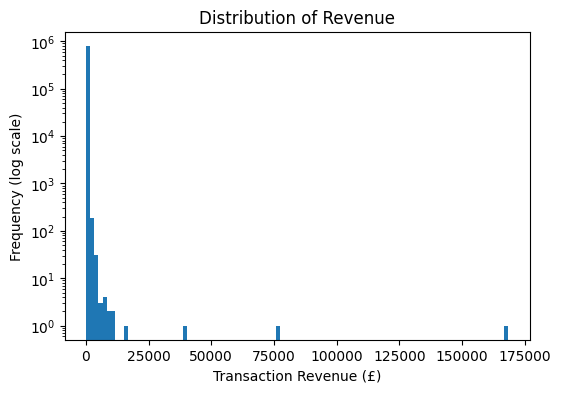

In [14]:
## Revenue distribution (log-scale)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(clean["revenue"], bins=100)
plt.yscale("log")
plt.xlabel("Transaction Revenue (£)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Revenue")
plt.show()


The transaction revenue distribution is highly right-skewed, with most transactions contributing relatively small amounts of revenue and a small number of extreme high-value transactions. This pattern is consistent with a mixed customer base that includes wholesale buyers placing bulk orders. As a result, mean-based metrics are not representative, motivating the use of robust feature scaling and log transformations in downstream modeling.


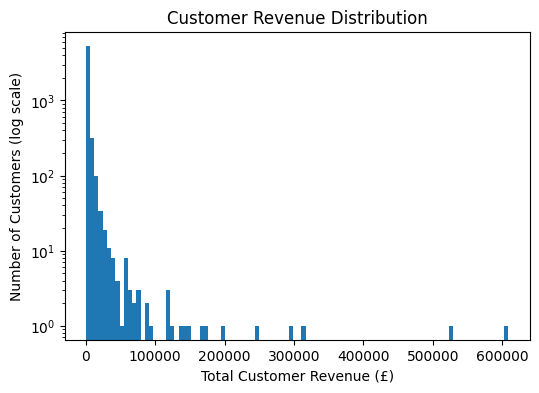

In [15]:
### Customer-level total spend
customer_revenue = (clean.groupby("customer_id")["revenue"].sum().sort_values(ascending=False))

plt.figure(figsize=(6,4))
plt.hist(customer_revenue, bins=100)
plt.yscale("log")
plt.xlabel("Total Customer Revenue (£)")
plt.ylabel("Number of Customers (log scale)")
plt.title("Customer Revenue Distribution")
plt.show()


Customer-level revenue exhibits a pronounced long-tail distribution, where a small subset of customers accounts for a disproportionate share of total revenue. This concentration highlights the importance of identifying and retaining high-value customers, and motivates the use of segmentation and CLV-based prioritization strategies.

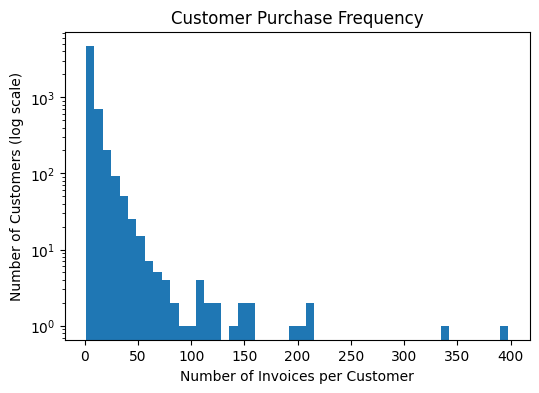

In [16]:
## Purchase frequency per customer
customer_freq = clean.groupby("customer_id")["invoice"].nunique()

plt.figure(figsize=(6,4))
plt.hist(customer_freq, bins=50)
plt.yscale("log")
plt.xlabel("Number of Invoices per Customer")
plt.ylabel("Number of Customers (log scale)")
plt.title("Customer Purchase Frequency")
plt.show()

Customer purchase frequency varies widely across the customer base. While many customers make only a small number of purchases, a minority exhibit highly frequent purchasing behavior, indicating strong engagement and potential wholesale activity. This variability suggests that frequency-based features will be highly informative for customer-level modeling.

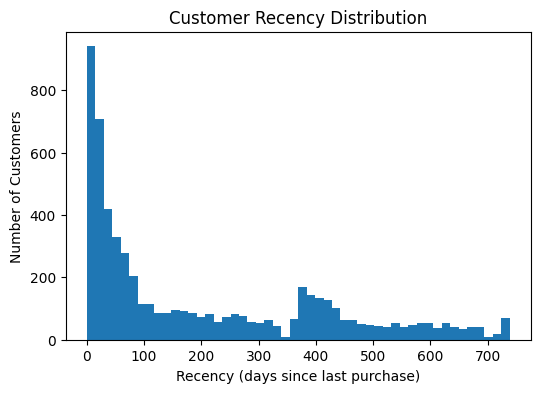

In [17]:
## Recency distribution
snapshot_date = clean["invoice_date"].max()

customer_recency = (
    snapshot_date - clean.groupby("customer_id")["invoice_date"].max()
).dt.days

plt.figure(figsize=(6,4))
plt.hist(customer_recency, bins=50)
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Number of Customers")
plt.title("Customer Recency Distribution")
plt.show()

Customer recency shows a broad distribution, ranging from very recent purchases to customers who have not purchased for over two years. This clear separation between active and inactive customers indicates that recency is a strong signal for customer engagement and potential churn risk.

#### EDA Summary

The exploratory analysis reveals substantial heterogeneity in customer behavior across revenue, purchase frequency, and recency. A small subset of customers drives a large share of revenue, while engagement levels vary significantly across the customer base. These patterns strongly justify customer-level feature engineering and motivate downstream segmentation, churn prediction, and CLV modeling.


## Customer-Level Feature Engineering

To support downstream segmentation, churn analysis, and lifetime value estimation, transaction-level data is aggregated from the train window only into customer-level behavioral features. These features summarize purchasing behavior across three key dimensions: recency, frequency, and monetary value.


In [18]:
snapshot_date = clean["invoice_date"].max()
snapshot_date

Timestamp('2011-12-09 12:50:00')

In [19]:
# RFM Features (train window only)
# Use train_end as the snapshot date to avoid leakage
snapshot_date = train_end

customer_features = (
    train
    .groupby("customer_id")
    .agg(
        recency_days=("invoice_date", lambda x: (snapshot_date - x.max()).days),
        frequency_invoices=("invoice", "nunique"),
        monetary=("revenue", "sum"),
        avg_order_value=("revenue", "mean"),
        avg_items_per_invoice=("quantity", "mean"),
        active_months=("invoice_date", lambda x: x.dt.to_period("M").nunique()),
        last_purchase=("invoice_date", "max")
    )
    .reset_index()
)

customer_features.head()


,customer_id,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months,last_purchase
0,12346.0,235,12,77556.46,2281.072353,2184.852941,5,2011-01-18 10:01:00
1,12347.0,39,6,4114.18,21.098359,12.400000,6,2011-08-02 08:48:00
2,12348.0,158,4,1709.40,35.612500,52.020833,4,2011-04-05 10:47:00
3,12349.0,317,3,2671.14,26.187647,9.735294,3,2010-10-28 08:23:00
4,12350.0,219,1,334.40,19.670588,11.588235,1,2011-02-02 16:01:00


In [20]:
customer_features.info()

<class 'pandas.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            5281 non-null   float64       
 1   recency_days           5281 non-null   int64         
 2   frequency_invoices     5281 non-null   int64         
 3   monetary               5281 non-null   float64       
 4   avg_order_value        5281 non-null   float64       
 5   avg_items_per_invoice  5281 non-null   float64       
 6   active_months          5281 non-null   int64         
 7   last_purchase          5281 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(4), int64(3)
memory usage: 330.2 KB


In [21]:
customer_features.describe().T

,count,mean,min,25%,50%,75%,max,std
customer_id,5281.0,15324.10017,12346.0,13850.0,15313.0,16807.0,18287.0,1712.323865
recency_days,5281.0,207.282901,0.0,49.0,164.0,326.0,648.0,175.007174
frequency_invoices,5281.0,5.745692,1.0,1.0,3.0,6.0,309.0,11.464582
monetary,5281.0,2705.436178,2.9,323.86,804.02,2118.75,484615.1,12535.825033
avg_order_value,5281.0,39.063667,1.45,11.468571,17.354429,24.355385,13305.5,277.652379
avg_items_per_invoice,5281.0,21.043025,1.0,5.42577,9.423077,14.104478,3501.587302,99.898776
active_months,5281.0,3.992804,1.0,1.0,2.0,5.0,22.0,4.02049
last_purchase,5281,2011-02-14 17:34:20.109827,2009-12-01 09:55:00,2010-10-18 15:37:00,2011-03-30 11:04:00,2011-07-22 13:53:00,2011-09-09 15:53:00,NaN


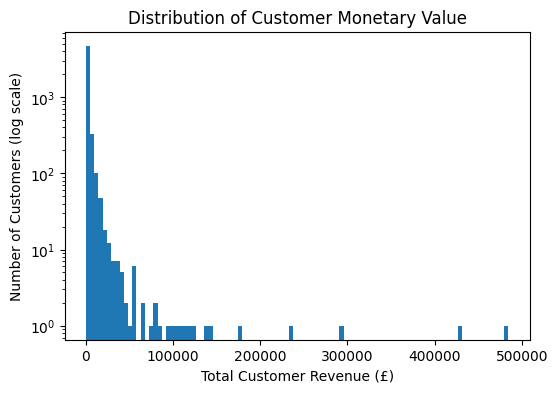

In [22]:
plt.figure(figsize=(6,4))
plt.hist(customer_features["monetary"], bins=100)
plt.yscale("log")
plt.xlabel("Total Customer Revenue (£)")
plt.ylabel("Number of Customers (log scale)")
plt.title("Distribution of Customer Monetary Value")
plt.show()


In [23]:
customer_features.to_csv("../data/processed/customer_features_train.csv", index=False)

## Customer Feature Insights

### Customer Activity
- 50% of customers have not purchased in the last **95 days**.
- ~25% of customers have been inactive for **over 1 year**.
- Only a small group of customers purchased very recently (within the last few days).

A large portion of customers are inactive, indicating clear opportunities for re-engagement and churn prevention.

---

### Purchase Frequency
- Median customer makes **3 purchases**.
- ~75% of customers make **7 or fewer purchases**.
- A small group of customers make **100+ purchases**, likely representing wholesale buyers.

Customer engagement varies widely and treating all customers the same would be inefficient.

---

### Revenue Contribution
- Median customer generates ~**£900** in revenue.
- Average revenue (~**£3,000**) is much higher due to a small number of high-value customers.
- A few customers generate **hundreds of thousands of pounds** in revenue.

Revenue is highly concentrated, and hence retaining a small number of high-value customers is critical to overall business performance.

---

### Customer Longevity
- Median customer is active for **3 months**.
- Some customers remain active for **over 2 years**.

This means long-term customers exist and should be identified for loyalty and retention programs.
